# Fallacy Identification Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from src.fallacies import get_fallacy_df, save_fallacy_df
from src.constants import RESPONSE_ERROR
from src.analysis import (
    get_sanity_check,
    add_identification_scores,
    get_macro_accuracies,
    add_llm_info,
    get_confusion_matrices,
    get_confusion_metrics,
    get_identification_confusion_metrics,
)
from src.plot import plot_accuracies, plot_identification_confusion_matrix
from src.llms import LLM, LLMGroup
from src.fallacies import add_taxonomy
import seaborn as sns
import pandas as pd

sns.set_theme()

# Set to True to add human data to the analysis
ADD_HUMAN_DATA = False

## Experiment 1.1: Fallacy Identification with zero-shot Prompt

In [2]:
filename_e11 = 'data/fallacies_e11.csv'
df_fallacies_e11 = get_fallacy_df(filename_e11)

[2024-11-17 12:30:39] Loaded existing fallacy dataframe from data/fallacies_e11.csv.


In [3]:
if ADD_HUMAN_DATA:
    df_human_fallacies_e11 = pd.read_csv('data/fallacies_e11_human.csv')
    df_human_fallacies_e11 = df_human_fallacies_e11.set_index('index').fillna('')
    
    # Consider only human responses for the q180 set
    # df_human_fallacies_e11 = df_human_fallacies_e11[df_human_fallacies_e11['q180'] == 1]
    
    # Add human responses to the e11 dataframe
    join_cols = [col for col in df_human_fallacies_e11.columns if col.endswith('_response')] + ['q180']
    df_fallacies_e11 = df_fallacies_e11.join(df_human_fallacies_e11[join_cols])
    df_fallacies_e11[join_cols] = df_fallacies_e11[join_cols].fillna('')
    
    # Limit all responses to the q180 set
    # df_fallacies_e11 = df_fallacies_e11[df_fallacies_e11['q180'] == 1]

### Scoring and Sanity Check

In [4]:
# If incomplete human data is added, don't punish missing responses
add_identification_scores(df_fallacies_e11, punish_missing=not ADD_HUMAN_DATA)

save_fallacy_df(df_fallacies_e11, filename_e11)

df_fallacies_e11.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,...,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score,o1_preview_pred,o1_preview_score,o1_mini_pred,o1_mini_score,claude_3_5_sonnet_20241022_pred,claude_3_5_sonnet_20241022_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,1,1,1


In [5]:
if ADD_HUMAN_DATA:
    # Add scoring to df_human_fallacies_e11 as well, so it can be looked at easily
    join_cols = ['fallacy', 'label', 'gpt_4_score', 'gpt_4o_score', 'claude_3_5_sonnet_score']
    df_human_fallacies_e11 = df_human_fallacies_e11.join(df_fallacies_e11[join_cols])
    add_identification_scores(df_human_fallacies_e11, punish_missing=False)
    
    # Save human errors
    df_human_fallacies_e11[df_human_fallacies_e11['adrian_score'] == 0].sort_index().to_csv('data/fallacies_e11_human_errors.csv')

In [6]:
# Check completeness of responses, predictions and scores
df_fallacies_e11.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 54 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   step                                 4640 non-null   object  
 1   entity                               4640 non-null   object  
 2   fallacy                              4640 non-null   category
 3   label                                4640 non-null   category
 4   category                             4640 non-null   category
 5   subcategory                          4640 non-null   category
 6   gpt_4o_response                      4640 non-null   object  
 7   gpt_4_response                       4640 non-null   object  
 8   gpt_4o_mini_response                 4640 non-null   object  
 9   claude_3_5_sonnet_response           4640 non-null   object  
 10  claude_3_opus_response               4640 non-null   object  
 11  claude_3_haiku_re

In [7]:
get_sanity_check(df_fallacies_e11)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,3.3,0,0
gpt_4,2.5,0,0
gpt_4o_mini,3.4,0,0
claude_3_5_sonnet,2.4,0,0
claude_3_opus,3.2,0,0
claude_3_haiku,3.3,0,0
gemini_1_5_pro,2.5,0,0
gemini_1_5_flash,2.4,0,0
gemini_1_5_flash_8b,2.4,0,0
llama_3_1_70b,2.7,0,1


### Overall Accuracies

In [8]:
_, df_subcategory_accuracies_e11, df_category_accuracies_e11, df_overall_accuracies_e11 = get_macro_accuracies(df_fallacies_e11)

In [9]:
df_overall_accuracies_e11 = df_overall_accuracies_e11.sort_values('accuracy', ascending=False)
df_overall_accuracies_e11

,accuracy
gpt_4,88.139394
gemini_1_5_pro,87.137212
gpt_4o,86.775211
o1_mini,85.851212
claude_3_5_sonnet_20241022,84.607844
claude_3_opus,83.946236
claude_3_5_sonnet,83.764299
gpt_4o_mini,83.049186
llama_3_1_70b,82.953173
gemini_1_5_flash,82.152709


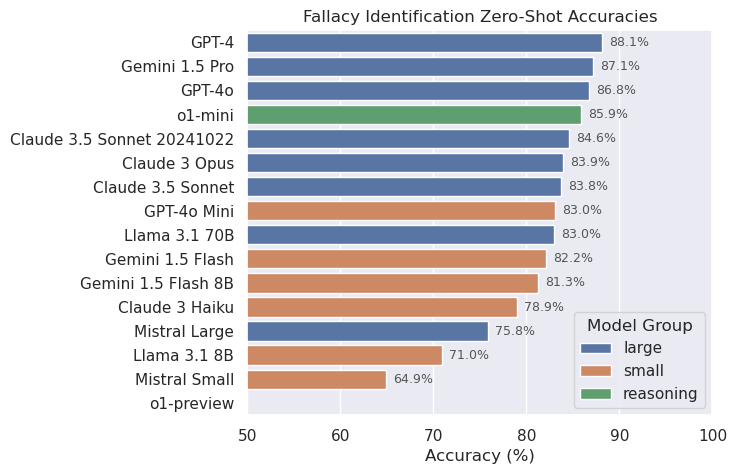

In [10]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e11),
    figsize=(6, 5),
    title='Fallacy Identification Zero-Shot Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

- GPT-4 still performs best, despite being a relatively outdated model. The overall accuracy of 88.1% is very close to the 87.7% obtained by Hong et al. (2024).
- The flagship models GPT-4, Gemini 1.5 Pro, and Claude 3.5 Sonnet perform similarly.
- The small models fall off in accuracy, but still achieve better results than the weaker models in the study by Hong et al. (2024).

### Fallacy Category Accuracies

In [11]:
df_category_accuracies_e11

category,formal,informal
gpt_4o,85.416667,88.133756
gpt_4,88.125,88.153787
gpt_4o_mini,79.010417,87.087956
claude_3_5_sonnet,85.0,82.528598
claude_3_opus,84.791667,83.100806
claude_3_haiku,75.677083,82.207172
gemini_1_5_pro,87.552083,86.72234
gemini_1_5_flash,81.614583,82.690834
gemini_1_5_flash_8b,78.854167,83.713282
llama_3_1_70b,82.03125,83.875096


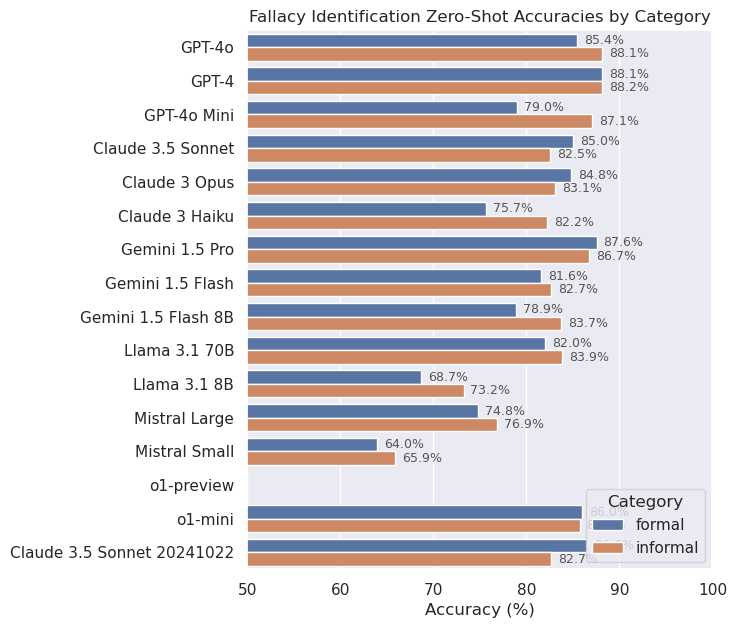

In [12]:
df_category_accuracies_long_e11 = pd.melt(df_category_accuracies_e11, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e11),
    figsize=(6, 7),
    title='Fallacy Identification Zero-Shot Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

- Lightweight models like GPT-4o Mini, Claude 3 Haiku, and Gemini 1.5 Flash 8B perform worse on formal compared to informal fallacy identification. This replicates the findings by Hong et al. (2024).
- The flagship models perform similarly on formal and informal fallacy identification.

In [13]:
df_plot = add_llm_info(df_category_accuracies_long_e11, group=True).groupby(['llm_group', 'category'], observed=True).mean().reset_index()
df_plot

,llm_group,category,accuracy
0,large,formal,84.283854
1,large,informal,84.004199
2,small,formal,74.635417
3,small,informal,79.141442
4,reasoning,formal,42.994792
5,reasoning,informal,43.335814


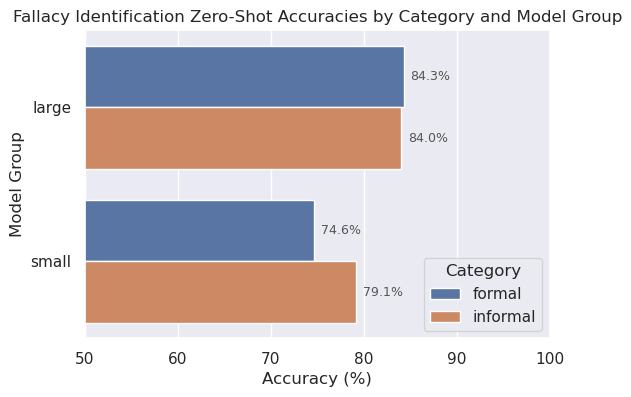

In [14]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies by Category and Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='category',
    legend_title='Category',
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    annotate=True,
    xlim=(50, 100),
)

- When grouping the LLMs into large and small models, the underperformance of small models on formal fallacies becomes more apparent.

### Fallacy Subcategory Accuracies

In [15]:
df_subcategory_accuracies_e11

category                          formal                                 \
subcategory                probabilistic propositional quantificational   
gpt_4o                              87.5     83.333333        80.833333   
gpt_4                              86.25     93.333333        84.166667   
gpt_4o_mini                         77.5          80.0        74.166667   
claude_3_5_sonnet                  81.25     86.666667        80.833333   
claude_3_opus                      83.75          85.0        86.666667   
claude_3_haiku                     78.75     69.166667        74.166667   
gemini_1_5_pro                     88.75          85.0        85.833333   
gemini_1_5_flash                   76.25     81.666667        81.666667   
gemini_1_5_flash_8b                76.25          77.5        76.666667   
llama_3_1_70b                       82.5          77.5             85.0   
llama_3_1_8b                       68.75          67.5        71.666667   
mistral_large_2                    71.25          67.5        76.666667   
mistral_small_2                     67.5     55.833333             65.0   
o1_preview                           0.0           0.0              0.0   
o1_mini                             82.5     88.333333             82.5   
claude_3_5_sonnet_20241022         86.25     86.666667        83.333333   

category                                 informal                            \
subcategory                syllogistic  ambiguity inappropriate presumption   
gpt_4o                            90.0       85.0                 87.037037   
gpt_4                            88.75  84.666667                 86.944444   
gpt_4o_mini                     84.375  84.333333                 87.037037   
claude_3_5_sonnet                91.25  78.666667                 84.259259   
claude_3_opus                    83.75       82.0                 83.981481   
claude_3_haiku                  80.625       81.0                 83.148148   
gemini_1_5_pro                  90.625  85.666667                 88.055556   
gemini_1_5_flash                86.875       80.0                 84.444444   
gemini_1_5_flash_8b               85.0  81.666667                  84.62963   
llama_3_1_70b                   83.125  83.666667                 84.444444   
llama_3_1_8b                    66.875  69.333333                 76.574074   
mistral_large_2                  83.75       74.0                 77.222222   
mistral_small_2                   67.5  63.333333                 66.296296   
o1_preview                         0.0        0.0                  1.851852   
o1_mini                         90.625  78.333333                 85.462963   
claude_3_5_sonnet_20241022        90.0  79.333333                 83.240741   

category                                                            
subcategory                inconsistency insufficiency irrelevance  
gpt_4o                         88.333333     92.413793   87.884615  
gpt_4                               85.0     93.965517   90.192308  
gpt_4o_mini                    86.666667      91.12069   86.282051  
claude_3_5_sonnet              81.666667     86.896552   81.153846  
claude_3_opus                  83.333333     86.637931   79.551282  
claude_3_haiku                 78.333333     85.862069   82.692308  
gemini_1_5_pro                      80.0     92.068966   87.820513  
gemini_1_5_flash               81.666667     86.637931   80.705128  
gemini_1_5_flash_8b            81.666667     88.103448        82.5  
llama_3_1_70b                       80.0     87.931034   83.333333  
llama_3_1_8b                        65.0     80.344828   74.935897  
mistral_large_2                78.333333      78.62069   76.153846  
mistral_small_2                     65.0     66.724138   68.205128  
o1_preview                           0.0      1.724138    1.217949  
o1_mini                             85.0     90.344828   89.423077  
claude_3_5_sonnet_20241022     83.333333     85.94827

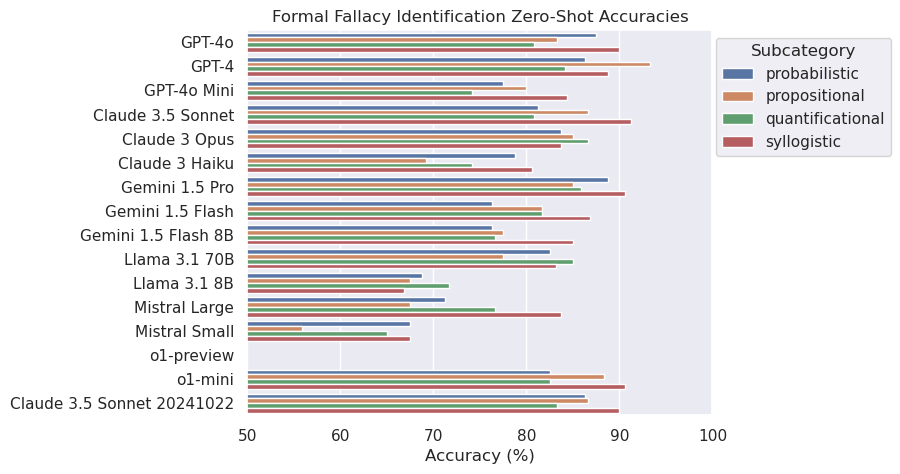

In [16]:
df_subcategory_accuracies_long_e11 = pd.melt(df_subcategory_accuracies_e11, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e11 = df_subcategory_accuracies_long_e11[
    df_subcategory_accuracies_long_e11['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e11),
    figsize=(6, 5),
    title='Formal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

In [17]:
df_plot = add_llm_info(df_formal_accuracies_long_e11, group=True).groupby(['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,formal,probabilistic,83.4375
1,large,formal,propositional,83.125
2,large,formal,quantificational,82.916667
3,large,formal,syllogistic,87.65625
4,small,formal,probabilistic,74.166667
5,small,formal,propositional,71.944444
6,small,formal,quantificational,73.888889
7,small,formal,syllogistic,78.541667
8,reasoning,formal,probabilistic,41.25
9,reasoning,formal,propositional,44.166667


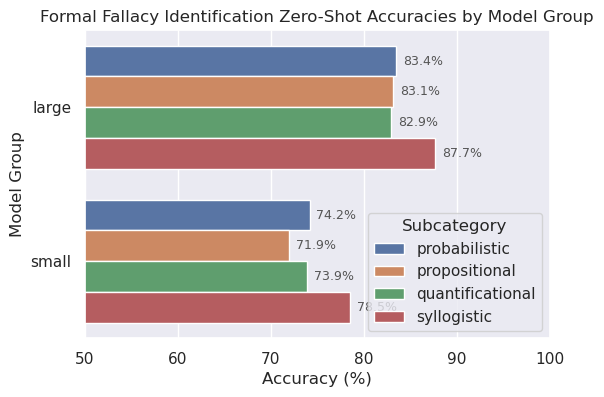

In [18]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Identification Zero-Shot Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    # order=[group.value for group in [LLMGroup.FLAGSHIP, LLMGroup.MEDIUM, LLMGroup.LIGHTWEIGHT]],
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Subcategory',
    annotate=True,
    xlim=(50, 100),
)

- Large models outperform small ones
- Both perform best on syllogistic formal fallacies


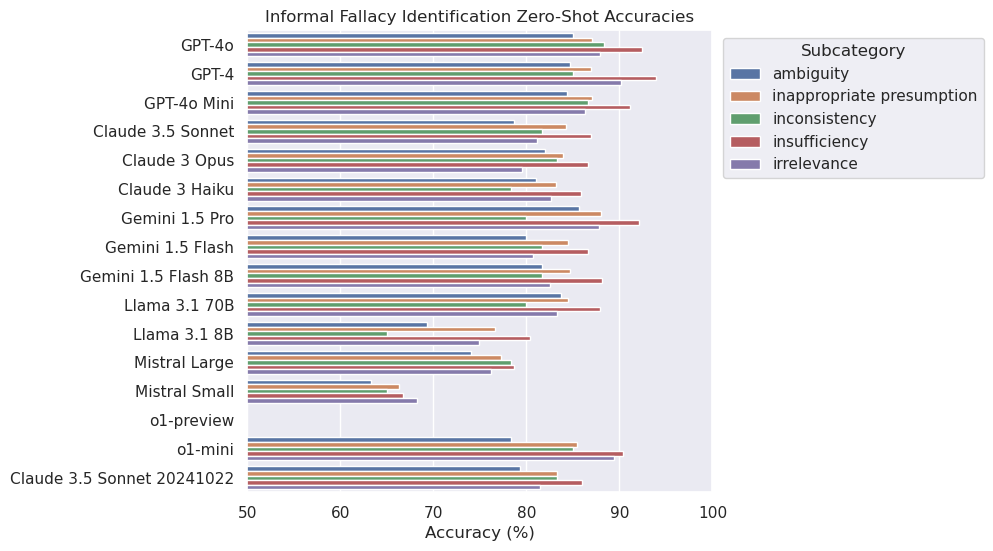

In [19]:
df_informal_accuracies_long_e11 = df_subcategory_accuracies_long_e11[
    df_subcategory_accuracies_long_e11['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e11),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

In [20]:
df_plot = add_llm_info(df_informal_accuracies_long_e11, group=True).groupby(['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,informal,ambiguity,81.625
1,large,informal,inappropriate presumption,84.398148
2,large,informal,inconsistency,82.5
3,large,informal,insufficiency,88.060345
4,large,informal,irrelevance,83.4375
5,small,informal,ambiguity,76.611111
6,small,informal,inappropriate presumption,80.354938
7,small,informal,inconsistency,76.388889
8,small,informal,insufficiency,83.132184
9,small,informal,irrelevance,79.220085


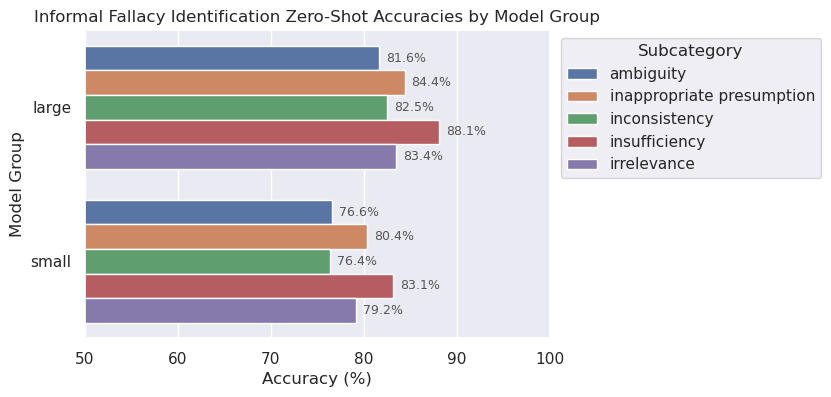

In [21]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Identification Zero-Shot Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    # order=[group.value for group in [LLMGroup.FLAGSHIP, LLMGroup.MEDIUM, LLMGroup.LIGHTWEIGHT]],
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=True,
    xlim=(50, 100),
)

- Small models perform a bit worse, but show the same pattern as large models
- Best performance for insufficiency fallacies (the premises are insufficient or weak to support the conclusion)


### Overall Confusion Metrics



In [22]:
df_confusion_matrices_e11 = get_confusion_matrices(df_fallacies_e11, 'label')

In [23]:
df_overall_confusion_matrix_e11 = df_confusion_matrices_e11.groupby(['label'], observed=True).sum()
df_overall_confusion_matrix_e11

actual,1,0
label,,
1,32346,9337
0,2476,25485


In [24]:
# We only care about the metrics for label 1 (fallacy)
df_overall_confusion_metrics_e11 = get_confusion_metrics(df_overall_confusion_matrix_e11)
df_overall_confusion_metrics_e11

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
1,32346,25485,9337,2476,0.83038,0.776000,0.928896,0.845592,0.0
0,25485,32346,2476,9337,0.83038,0.911448,0.731865,0.811844,0.0


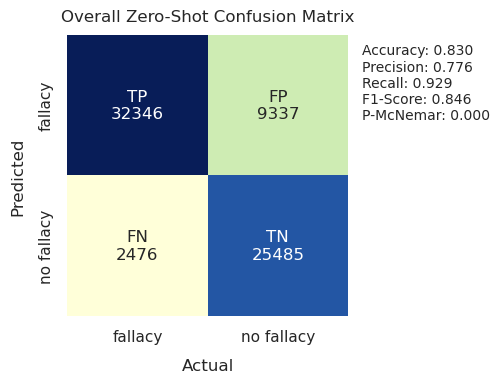

In [25]:
plot_identification_confusion_matrix(
    df_overall_confusion_metrics_e11.loc[1],
    title='Overall Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- LLMs tend to generate false alarms (judge valid reasoning as invalid)
- The overall accuracy of 83.0% is very high.

### LLM Confusion Metrics

In [26]:
df_llm_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'llm')
df_llm_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
claude_3_5_sonnet,2209,1672,648,111,0.836,0.773,0.952,0.853,0.000
claude_3_5_sonnet_20241022,2178,1693,625,142,0.835,0.777,0.939,0.850,0.000
claude_3_haiku,2203,1635,685,117,0.827,0.763,0.950,0.846,0.000
claude_3_opus,2191,1665,655,129,0.831,0.770,0.944,0.848,0.000
gemini_1_5_flash,2159,1702,618,161,0.832,0.777,0.931,0.847,0.000
gemini_1_5_flash_8b,2133,1766,554,187,0.840,0.794,0.919,0.852,0.000
gemini_1_5_pro,2090,2025,295,230,0.887,0.876,0.901,0.888,0.005
gpt_4,2017,2148,172,303,0.898,0.921,0.869,0.895,0.000
gpt_4o,2031,2071,249,289,0.884,0.891,0.875,0.883,0.093
gpt_4o_mini,2086,1944,376,234,0.869,0.847,0.899,0.872,0.000


- Note that the accuracies differ from the macro-averaged accuracies, as the confusion matrix is calculated on the level of individual reasoning steps.

### Large vs. Small Model Confusion Metrics



In [27]:
df_group_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'llm_group')
df_group_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
large,17162,14320,4237,1398,0.848,0.802,0.925,0.859,0.000
small,13142,9080,4840,778,0.798,0.731,0.944,0.824,0.000
reasoning,2042,2085,260,300,0.881,0.887,0.872,0.879,0.099


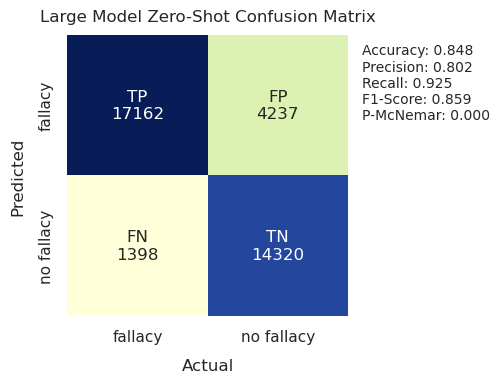

In [28]:
plot_identification_confusion_matrix(
    df_group_confusion_metrics_e11.loc[LLMGroup.LARGE.value],
    title='Large Model Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

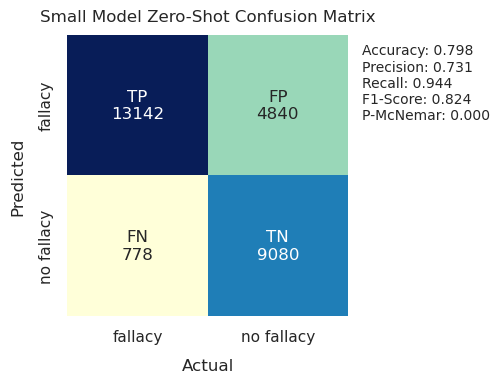

In [29]:
plot_identification_confusion_matrix(
    df_group_confusion_metrics_e11.loc[LLMGroup.SMALL.value],
    title='Small Model Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- Small models have a stronger tendency to generate false positives than large models (judge valid reasoning as invalid)



### Best vs. Worst Model Confusion Metrics

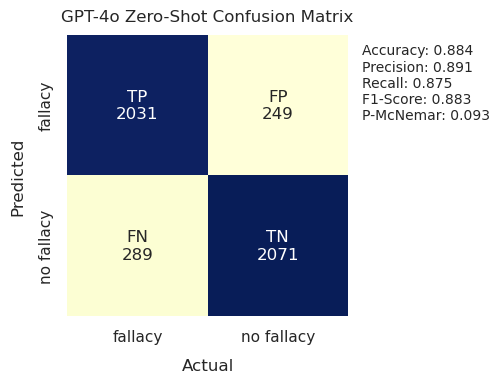

In [30]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e11.loc[LLM.GPT_4O.key],
    title=f'{LLM.GPT_4O.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- The best models have no bias towards false positives or false negatives.

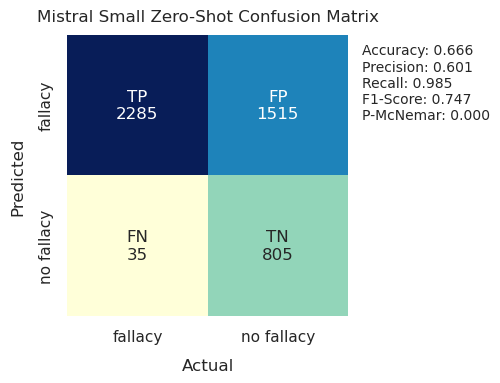

In [31]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e11.loc[LLM.MISTRAL_SMALL_2.key],
    title=f'{LLM.MISTRAL_SMALL_2.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- The worst models have a strong bias towards false positives.

### Category Confusion Metrics

In [32]:
df_category_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'category')
df_category_confusion_metrics_e11 = df_category_confusion_metrics_e11
df_category_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
formal,3205,2621,979,395,0.809,0.766,0.890,0.823,0.0
informal,29141,22864,8358,2081,0.833,0.777,0.933,0.848,0.0


- False positives are more common than false negatives for both categories.

### Subcategory Confusion Metrics

In [33]:
df_subcategory_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'subcategory')
df_subcategory_confusion_metrics_e11 = df_subcategory_confusion_metrics_e11
df_subcategory_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
ambiguity,1969,1604,645,281,0.794,0.753,0.875,0.810,0.0
inappropriate presumption,7364,6078,2031,743,0.829,0.784,0.908,0.842,0.0
inconsistency,423,299,151,27,0.802,0.737,0.940,0.826,0.0
insufficiency,8305,6721,1985,401,0.863,0.807,0.954,0.874,0.0
irrelevance,11080,8162,3546,629,0.822,0.758,0.946,0.841,0.0
probabilistic,588,368,232,12,0.797,0.717,0.980,0.828,0.0
propositional,795,627,273,105,0.790,0.744,0.883,0.808,0.0
quantificational,774,653,247,126,0.793,0.758,0.860,0.806,0.0
syllogistic,1048,973,227,152,0.842,0.822,0.873,0.847,0.0


- False positives are more common than false negatives for all subcategories.

### Fallacy Confusion Metrics

In [34]:
df_fallacy_confusion_metrics = get_identification_confusion_metrics(df_confusion_matrices_e11, 'fallacy')
add_taxonomy(df_fallacy_confusion_metrics.sort_values('accuracy', ascending=True)).round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar,category,subcategory
Having Your Cake,31,114,36,119,0.483,0.463,0.207,0.286,0.000,informal,irrelevance
Stereotyping the fallacy,34,117,33,116,0.503,0.507,0.227,0.313,0.000,informal,insufficiency
Illicit Substitution of Identicals,39,118,32,111,0.523,0.549,0.260,0.353,0.000,formal,syllogistic
Argument by Repetition,76,82,68,74,0.527,0.528,0.507,0.517,0.675,informal,inappropriate presumption
Existential Fallacy,44,118,32,106,0.540,0.579,0.293,0.389,0.000,formal,quantificational
...,...,...,...,...,...,...,...,...,...,...,...
Argument from Incredulity,150,137,13,0,0.957,0.920,1.000,0.958,0.000,informal,inappropriate presumption
Texas Sharpshooter Fallacy,150,137,13,0,0.957,0.920,1.000,0.958,0.000,informal,insufficiency
Confusing Currently Unexplained with Unexplainable,150,143,7,0,0.977,0.955,1.000,0.977,0.016,informal,insufficiency
Appeal to Complexity,150,146,4,0,0.987,0.974,1.000,0.987,0.125,informal,irrelevance


- These are the fallacy types for which the models perform worst (lowest accuracy)

### Human Confusion Matrix: Adrian

In [35]:
if ADD_HUMAN_DATA:
    plot_identification_confusion_matrix(
        df_llm_confusion_metrics_e11.loc[LLM.ADRIAN.key],
        title=f'{LLM.ADRIAN.label} Zero-Shot Confusion Matrix',
        figsize=(5, 4),
    )

## Experiment 1.2: Fallacy Identification with few-shot Prompt

In [36]:
filename_e12 = 'data/fallacies_e12.csv'
df_fallacies_e12 = get_fallacy_df(filename_e12)

[2024-11-17 12:31:00] Loaded existing fallacy dataframe from data/fallacies_e12.csv.


### Scoring and Sanity Check

In [37]:
add_identification_scores(df_fallacies_e12)

save_fallacy_df(df_fallacies_e12, filename_e12)

df_fallacies_e12.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No.,Yes.,No.,...,1,1,0,0,1,1,NaN,0,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1


In [38]:
# Check completeness of responses, predictions and scores
df_fallacies_e12.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   claude_3_5_sonnet_response    4640 non-null   object  
 8   gemini_1_5_pro_response       4640 non-null   object  
 9   gpt_4o_mini_response          4640 non-null   object  
 10  claude_3_haiku_response       4640 non-null   object  
 11  gemini_1_5_flash_response     4640 non-null   object  
 12  gemini_1_5_flash_8b_response  4640 non-null   ob

In [39]:
get_sanity_check(df_fallacies_e12)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,3.7,0,9
claude_3_5_sonnet,3.4,0,0
gemini_1_5_pro,3.5,0,4
gpt_4o_mini,3.5,0,0
claude_3_haiku,3.7,0,63
gemini_1_5_flash,3.0,0,218
gemini_1_5_flash_8b,2.5,0,1
llama_3_1_70b,3.0,0,52
llama_3_1_8b,4.3,0,23
mistral_large_2,8.8,0,1241


- Weaker LLMs had some issues with the few-shot prompts, responding with "Yes No No Yes Yes" sometimes.
- Mistral Large responded "Yes. No. No. Yes. Yes." 1241 times, and accuracy cannot be reliably determined. This model is therefore excluded from the analysis.

In [40]:
df_fallacies_e12.drop(columns=LLM.MISTRAL_LARGE_2.key + '_score' , inplace=True)

### Overall Accuracies

In [41]:
_, df_subcategory_accuracies_e12, df_category_accuracies_e12, df_overall_accuracies_e12 = get_macro_accuracies(df_fallacies_e12)

In [42]:
df_overall_accuracies_e12 = df_overall_accuracies_e12.sort_values('accuracy', ascending=False)
df_overall_accuracies_e12

,accuracy
gemini_1_5_pro,85.684072
gpt_4o,85.421126
claude_3_5_sonnet,85.39816
gpt_4o_mini,84.163461
llama_3_1_70b,81.705942
gemini_1_5_flash_8b,77.53575
llama_3_1_8b,75.410476
gemini_1_5_flash,72.702111
mistral_small_2,72.124162
claude_3_haiku,71.22162


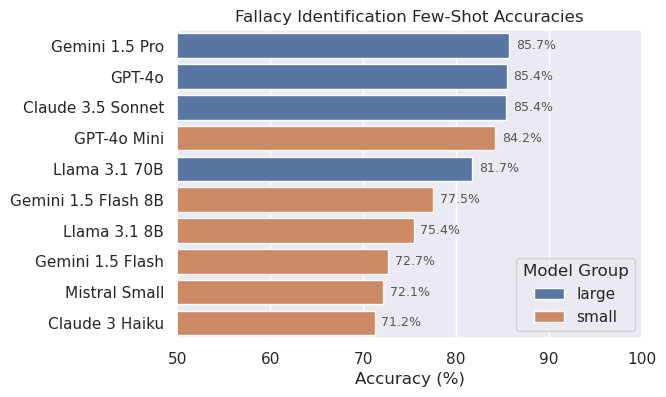

In [43]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e12),
    figsize=(6, 4),
    title='Fallacy Identification Few-Shot Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)


- Mistral Large responded "Yes. No. No. Yes. Yes." hundreds of times, which explains the low accuracy.

### Fallacy Category Accuracies

In [44]:
df_category_accuracies_e12

category,formal,informal
gpt_4o,84.791667,86.050585
claude_3_5_sonnet,85.78125,85.01507
gemini_1_5_pro,84.947917,86.420228
gpt_4o_mini,81.979167,86.347755
claude_3_haiku,69.583333,72.859908
gemini_1_5_flash,71.458333,73.945889
gemini_1_5_flash_8b,76.302083,78.769417
llama_3_1_70b,78.489583,84.922301
llama_3_1_8b,68.854167,81.966785
mistral_small_2,69.166667,75.081658


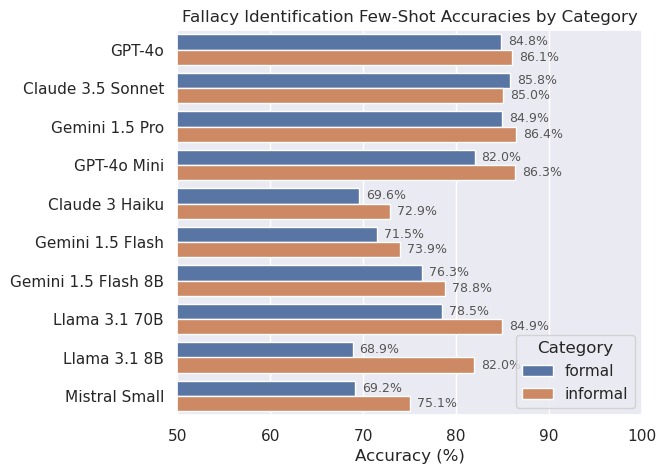

In [45]:
df_category_accuracies_long_e12 = pd.melt(df_category_accuracies_e12, var_name='category', value_name='accuracy', ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e12),
    figsize=(6, 5),
    title='Fallacy Identification Few-Shot Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [46]:
df_subcategory_accuracies_e12

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       87.5          85.0        76.666667        90.0   
claude_3_5_sonnet            85.0          82.5             85.0      90.625   
gemini_1_5_pro              86.25     83.333333        83.333333      86.875   
gpt_4o_mini                 76.25     88.333333        75.833333        87.5   
claude_3_haiku               70.0     60.833333             70.0        77.5   
gemini_1_5_flash            71.25          62.5        68.333333       83.75   
gemini_1_5_flash_8b          75.0          72.5        73.333333      84.375   
llama_3_1_70b               86.25          65.0        80.833333      81.875   
llama_3_1_8b                 67.5     70.833333        65.833333       71.25   
mistral_small_2              70.0     59.166667             70.0        77.5   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o               84.666667                 86.481481     83.333333   
claude_3_5_sonnet         83.0                 84.259259     88.333333   
gemini_1_5_pro            85.0                  85.37037     83.333333   
gpt_4o_mini          84.333333                 87.314815     81.666667   
claude_3_haiku       73.333333                 74.074074     71.666667   
gemini_1_5_flash          74.0                      72.5          75.0   
gemini_1_5_flash_8b  79.666667                 78.148148     78.333333   
llama_3_1_70b        83.666667                 85.462963     81.666667   
llama_3_1_8b         84.666667                 80.277778     76.666667   
mistral_small_2      72.333333                 77.407407     71.666667   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  90.258621   85.512821  
claude_3_5_sonnet       86.982759        82.5  
gemini_1_5_pro               90.0   88.397436  
gpt_4o_mini             90.603448   87.820513  
claude_3_haiku           73.87931   71.346154  
gemini_1_5_flash        72.844828   75.384615  
gemini_1_5_flash_8b     80.775862   76.923077  
llama_3_1_70b            88.87931   84.935897  
llama_3_1_8b            87.068966   81.153846  
mistral_small_2         78.103448   75.897436

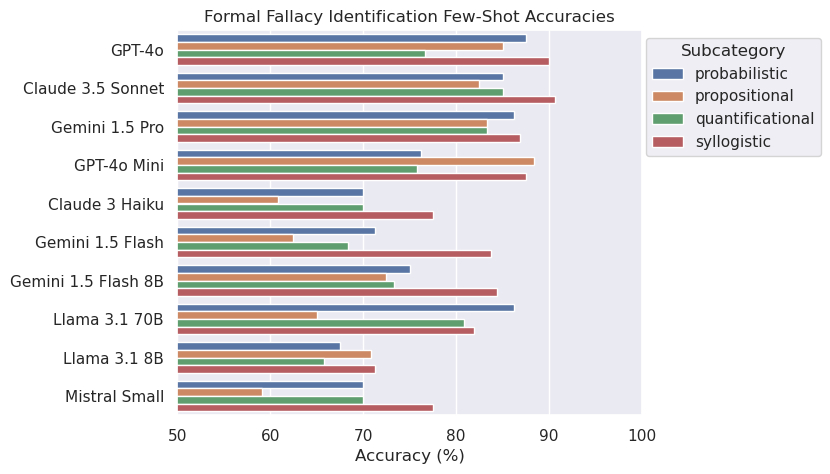

In [47]:
df_subcategory_accuracies_long_e12 = pd.melt(df_subcategory_accuracies_e12, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e12 = df_subcategory_accuracies_long_e12[
    df_subcategory_accuracies_long_e12['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e12),
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

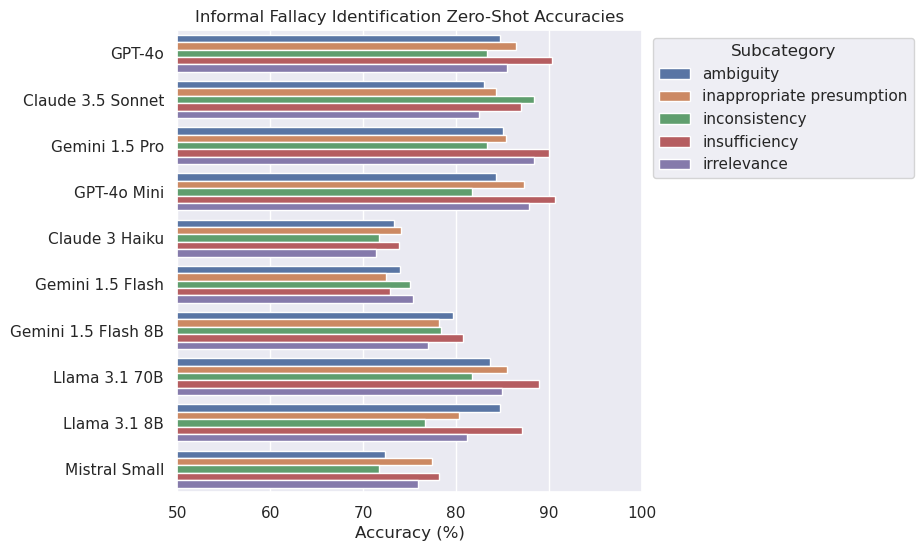

In [48]:
df_informal_accuracies_long_e12 = df_subcategory_accuracies_long_e12[
    df_subcategory_accuracies_long_e12['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e12),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

## Experiment 1.3: Fallacy Identification with chain-of-thought Prompt

In [49]:
filename_e13 = 'data/fallacies_e13.csv'
df_fallacies_e13 = get_fallacy_df(filename_e13)

[2024-11-17 12:31:04] Loaded existing fallacy dataframe from data/fallacies_e13.csv.


### Scoring and Sanity Check

In [50]:
add_identification_scores(df_fallacies_e13)

save_fallacy_df(df_fallacies_e13, filename_e13)

df_fallacies_e13.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. Joh...,No. Silence is not necessarily an admission o...,No.,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. Bob's s...,Let's think through this step by step: 1. Ali...,No. Silence could indicate a lack of knowledg...,No.,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The con...,Let's think through this step-by-step: 1. Ali...,No. Bob's silence doesn't confirm Alice's cla...,No.,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. The...,"No. While Tom's experience is valuable, the a...",No.,...,1,1,1,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The fac...,Let's think through this step-by-step: 1. Joh...,No. Silence does not imply guilt or fear. Ma...,No.,...,1,1,1,1,1,1,1,1,1,1


In [51]:
# Check completeness of responses, predictions and scores
df_fallacies_e13.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   claude_3_5_sonnet_response    4640 non-null   object  
 8   gemini_1_5_pro_response       4638 non-null   object  
 9   gpt_4o_mini_response          4640 non-null   object  
 10  claude_3_haiku_response       4640 non-null   object  
 11  gemini_1_5_flash_response     4639 non-null   object  
 12  gemini_1_5_flash_8b_response  4640 non-null   ob

In [52]:
get_sanity_check(df_fallacies_e13)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,340.4,0,32
claude_3_5_sonnet,1160.1,0,58
gemini_1_5_pro,199.4,2,26
gpt_4o_mini,5.9,0,0
claude_3_haiku,826.4,0,71
gemini_1_5_flash,245.0,1,6
gemini_1_5_flash_8b,222.8,0,0
llama_3_1_70b,904.7,0,149
llama_3_1_8b,757.9,0,19
mistral_large_2,373.2,0,9


- Chain of thought responses are longer and more complex. In a few cases, a clear Yes/No answer cannot be determined.
- GPT-4o Mini's low average response lenght indicates that it ignored the chain-of-thought instructions and just responded with Yes/No.

In [53]:
# Show invalid responses
df_invalid_predictions_e13 = df_fallacies_e13[df_fallacies_e13.isna().any(axis=1)]
df_invalid_predictions_e13.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
16,Since Samantha claims that wheelbirds exist in...,wheelbirds,Argument from Silence,0,informal,insufficiency,Yes. The reasoning is correct. Samantha's clai...,Let's think through this step by step: 1. Sam...,"Yes. Samantha's claim without evidence, coupl...",Yes.,...,0,1,0,1,1,0,0,1,0,1
36,Since I declare that the city of Bergamo is th...,bergamo,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes.,Let's break this down step by step: 1. The st...,Yes,Yes.,...,0,1,NaN,0,1,0,0,1,0,1
37,Since I claim that benzopyran has magical prop...,benzopyran,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes. The reasoning step is correct. Claims abo...,Let's break this down step by step: 1. The st...,Yes,Yes.,...,0,1,NaN,0,1,0,0,1,0,1
57,Since seining is a traditional fishing method ...,seining,Political Correctness Fallacy,0,informal,irrelevance,Yes. The reasoning step acknowledges the cultu...,Let's break down this reasoning step by step: ...,Yes. The reasoning acknowledges the value of ...,Yes.,...,0,1,NaN,0,0,1,0,1,0,1
75,Since ghetto fences are either a symbol of sep...,ghetto fences,Affirming a Disjunct,0,formal,propositional,Yes. The reasoning is correct. The statement a...,Let's break this down step by step: 1. The st...,Yes. The premise states the fences can be *ei...,Yes.,...,0,1,NaN,0,0,1,0,1,1,0


### Overall Accuracies

In [54]:
_, df_subcategory_accuracies_e13, df_category_accuracies_e13, df_overall_accuracies_e13 = get_macro_accuracies(df_fallacies_e13)

In [55]:
df_overall_accuracies_e13 = df_overall_accuracies_e13.sort_values('accuracy', ascending=False)
df_overall_accuracies_e13

,accuracy
gpt_4o,86.372656
gemini_1_5_pro,82.819718
gpt_4o_mini,81.568066
claude_3_5_sonnet,80.841547
llama_3_1_70b,80.500681
claude_3_haiku,79.89726
gemini_1_5_flash,79.845382
mistral_large_2,79.572555
gemini_1_5_flash_8b,77.709173
mistral_small_2,71.147021


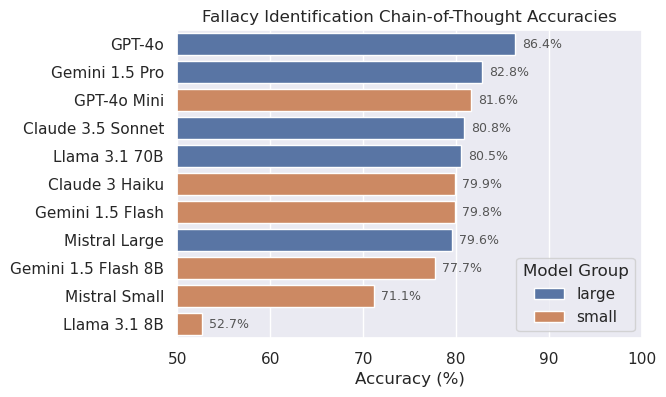

In [56]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e13),
    figsize=(6, 4),
    title='Fallacy Identification Chain-of-Thought Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Category Accuracies

In [57]:
df_category_accuracies_e13

category,formal,informal
gpt_4o,83.177083,89.568229
claude_3_5_sonnet,81.302083,80.38101
gemini_1_5_pro,81.041667,84.59777
gpt_4o_mini,76.197917,86.938216
claude_3_haiku,73.541667,86.252854
gemini_1_5_flash,80.260417,79.430347
gemini_1_5_flash_8b,75.3125,80.105845
llama_3_1_70b,78.385417,82.615945
llama_3_1_8b,49.947917,55.478014
mistral_large_2,77.760417,81.384694


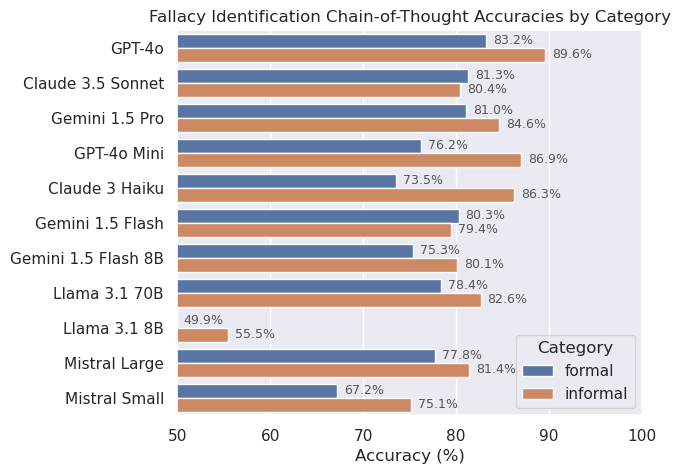

In [58]:
df_category_accuracies_long_e13 = pd.melt(df_category_accuracies_e13, var_name='category', value_name='accuracy',
                                         ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e13),
    figsize=(6, 5),
    title='Fallacy Identification Chain-of-Thought Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [59]:
df_subcategory_accuracies_e13

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       87.5     83.333333             82.5      79.375   
claude_3_5_sonnet            85.0     90.833333             75.0      74.375   
gemini_1_5_pro               82.5          87.5        79.166667        75.0   
gpt_4o_mini                  77.5     74.166667             72.5      80.625   
claude_3_haiku               77.5     74.166667             72.5        70.0   
gemini_1_5_flash             77.5     81.666667             77.5      84.375   
gemini_1_5_flash_8b         76.25     70.833333        74.166667        80.0   
llama_3_1_70b               81.25     86.666667             77.5      68.125   
llama_3_1_8b                51.25     50.833333        48.333333      49.375   
mistral_large_2              80.0          67.5        79.166667      84.375   
mistral_small_2             71.25          62.5             70.0        65.0   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o               86.666667                 88.055556     91.666667   
claude_3_5_sonnet    74.333333                 82.962963     81.666667   
gemini_1_5_pro       82.333333                 86.203704          80.0   
gpt_4o_mini          83.666667                 87.962963     86.666667   
claude_3_haiku       84.333333                 87.037037     86.666667   
gemini_1_5_flash          80.0                  79.62963     81.666667   
gemini_1_5_flash_8b       78.0                 78.981481     83.333333   
llama_3_1_70b        80.666667                 84.444444     76.666667   
llama_3_1_8b              54.0                 56.944444          50.0   
mistral_large_2           81.0                 82.685185          80.0   
mistral_small_2           70.0                      77.5     73.333333   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                  92.413793   89.038462  
claude_3_5_sonnet       84.224138   78.717949  
gemini_1_5_pro          88.362069   86.089744  
gpt_4o_mini             90.689655   85.705128  
claude_3_haiku          87.586207   85.641026  
gemini_1_5_flash        80.086207   75.769231  
gemini_1_5_flash_8b     82.586207   77.628205  
llama_3_1_70b           87.327586   83.974359  
llama_3_1_8b            59.137931   57.307692  
mistral_large_2          83.87931   79.358974  
mistral_small_2         77.327586   77.371795

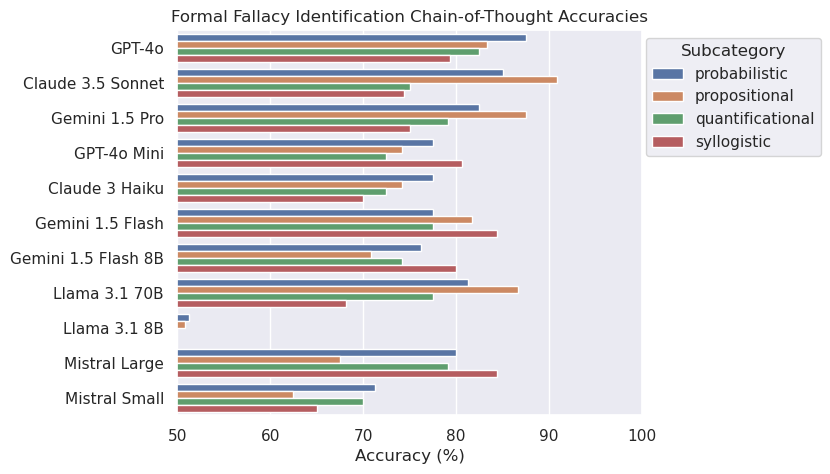

In [60]:
df_subcategory_accuracies_long_e13 = pd.melt(df_subcategory_accuracies_e13, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e13 = df_subcategory_accuracies_long_e13[df_subcategory_accuracies_long_e13['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e13),
    figsize=(6, 5),
    title='Formal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',    
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

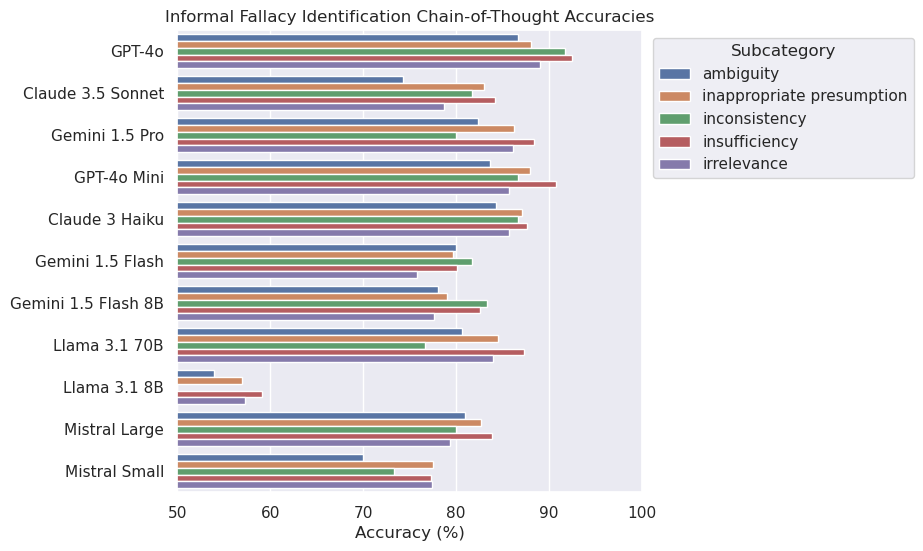

In [61]:
df_informal_accuracies_long_e13 = df_subcategory_accuracies_long_e13[df_subcategory_accuracies_long_e13['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e13),
    figsize=(6, 6),
    title='Informal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

### Llama 3.1 8B Confusion Matrix

In [62]:
df_confusion_matrices_e13 = get_confusion_matrices(df_fallacies_e13, 'label')

In [63]:
df_llm_confusion_metrics_e13 = get_identification_confusion_metrics(df_confusion_matrices_e13, 'llm')
df_llm_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
claude_3_5_sonnet,2209,1672,648,111,0.836,0.773,0.952,0.853,0.000
claude_3_5_sonnet_20241022,2178,1693,625,142,0.835,0.777,0.939,0.850,0.000
claude_3_haiku,2203,1635,685,117,0.827,0.763,0.950,0.846,0.000
claude_3_opus,2191,1665,655,129,0.831,0.770,0.944,0.848,0.000
gemini_1_5_flash,2159,1702,618,161,0.832,0.777,0.931,0.847,0.000
gemini_1_5_flash_8b,2133,1766,554,187,0.840,0.794,0.919,0.852,0.000
gemini_1_5_pro,2090,2025,295,230,0.887,0.876,0.901,0.888,0.005
gpt_4,2017,2148,172,303,0.898,0.921,0.869,0.895,0.000
gpt_4o,2031,2071,249,289,0.884,0.891,0.875,0.883,0.093
gpt_4o_mini,2086,1944,376,234,0.869,0.847,0.899,0.872,0.000


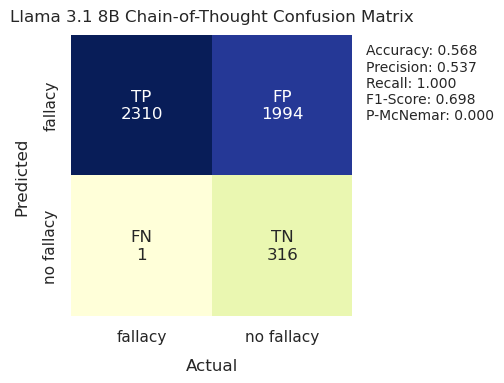

In [64]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e13.loc[LLM.LLAMA_3_1_8B.key],
    title=f'{LLM.LLAMA_3_1_8B.label} Chain-of-Thought Confusion Matrix',
    figsize=(5, 4),
)

- The very low Llama 3.1 8B accuracy is explained by an extremely high false positive rate.

## Prompt Method Comparison

In [65]:
df_overall_accuracies_e11['method'] = 'zero-shot'
df_overall_accuracies_e12['method'] = 'few-shot'
df_overall_accuracies_e13['method'] = 'chain-of-thought'
df_method_accuracies = pd.concat([df_overall_accuracies_e11, df_overall_accuracies_e12, df_overall_accuracies_e13])

# Select models which have been prompted with all methods
prompt_comparison_llms = [
    LLM.GPT_4O, LLM.GEMINI_1_5_PRO, LLM.CLAUDE_3_5_SONNET, LLM.MISTRAL_LARGE_2,
    LLM.GPT_4O_MINI, LLM.GEMINI_1_5_FLASH, LLM.GEMINI_1_5_FLASH_8B, LLM.CLAUDE_3_HAIKU, LLM.MISTRAL_SMALL_2
]

df_method_accuracies = df_method_accuracies.loc[[llm.key for llm in prompt_comparison_llms]]

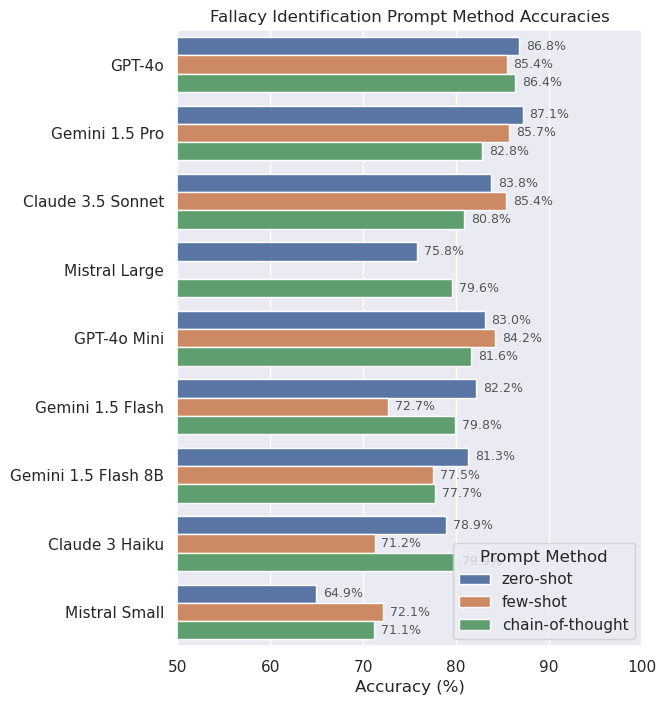

In [66]:
plot_accuracies(
    data=add_llm_info(df_method_accuracies),
    figsize=(6, 8),
    title='Fallacy Identification Prompt Method Accuracies',
    hue='method',
    legend_title='Prompt Method',
    annotate=True,
    xlim=(50, 100),
)

In [67]:
df_plot = add_llm_info(df_method_accuracies, group=True).groupby(['llm_group', 'method'], observed=True).mean().sort_values('method', ascending=False).reset_index()
df_plot

,llm_group,method,accuracy
0,large,zero-shot,83.376391
1,small,zero-shot,78.072561
2,large,few-shot,85.501119
3,small,few-shot,75.549421
4,large,chain-of-thought,82.401619
5,small,chain-of-thought,78.03338


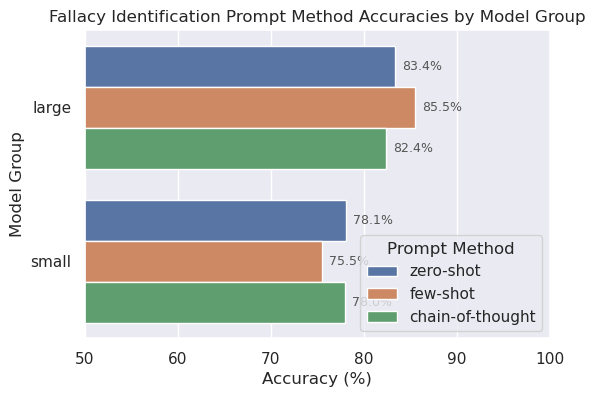

In [68]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Prompt Method Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='method',
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Prompt Method',
    annotate=True,
    xlim=(50, 100),
)

- Few-shot and chain-of-thought prompts don't seem to improve the accuracies, compared to zero-shot prompts.
- Some of the small models seem to get confused by few-shot prompts sometimes, responding with "Yes No No Yes Yes".

## Experiment 1.4: Fallacy Identification with Fine-Tuning

In [69]:
filename_e14 = 'data/fallacies_e14.csv'
df_fallacies_e14 = get_fallacy_df(filename_e14)

[2024-11-17 12:31:17] Loaded existing fallacy dataframe from data/fallacies_e14.csv.


### Scoring and Sanity Check

In [70]:
add_identification_scores(df_fallacies_e14)

save_fallacy_df(df_fallacies_e14, filename_e14)

# Check completeness of responses
df_fallacies_e14.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   step                                 2320 non-null   object  
 1   entity                               2320 non-null   object  
 2   fallacy                              2320 non-null   category
 3   label                                2320 non-null   category
 4   category                             2320 non-null   category
 5   subcategory                          2320 non-null   category
 6   tuning                               2320 non-null   object  
 7   gpt_4o_mini_identification_response  2320 non-null   object  
 8   gpt_4o_mini_identification_pred      2320 non-null   category
 9   gpt_4o_mini_identification_score     2320 non-null   UInt8   
dtypes: UInt8(1), category(5), object(4)
memory usage: 101.4+ KB


In [71]:
get_sanity_check(df_fallacies_e14)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o_mini_identification,2.5,0,0


In [72]:
df_confusion_matrices_e14 = get_confusion_matrices(df_fallacies_e14, 'label')

In [73]:
# Answers from zero-shot identification (experiment 1.1) will be compared with fine-tuned models.
df_fallacies_e14 = df_fallacies_e14.merge(
    df_fallacies_e11.drop(columns=['step', 'category', 'subcategory']),
    on=['entity', 'fallacy', 'label'],
)

### Overall Accuracies

In [74]:
_, df_subcategory_accuracies_e14, df_category_accuracies_e14, df_overall_accuracies_e14 = get_macro_accuracies(df_fallacies_e14)

In [75]:
df_overall_accuracies_e14 = df_overall_accuracies_e14.sort_values('accuracy', ascending=False)
df_overall_accuracies_e14.round(1)

,accuracy
gpt_4o_mini_identification,93.1
gpt_4,87.7
gemini_1_5_pro,86.9
o1_mini,85.8
gpt_4o,85.3
claude_3_5_sonnet,85.1
claude_3_5_sonnet_20241022,84.3
claude_3_opus,83.0
gemini_1_5_flash,82.3
llama_3_1_70b,82.2


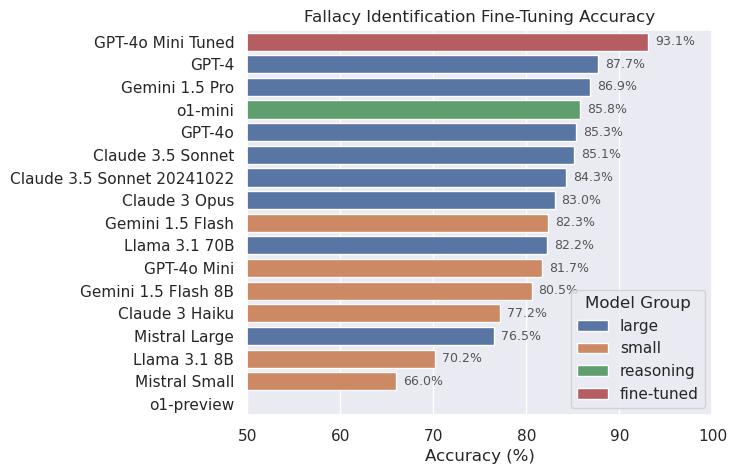

In [76]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e14),
    figsize=(6, 5),
    title='Fallacy Identification Fine-Tuning Accuracy',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

- Fine-tuning leads to massive increases in identification accuracy.
- Accuracies differ slightly compared to experiment 1.1, they are calculated for the fine-tuning test set.

### Fallacy Category Accuracies

In [77]:
df_category_accuracies_e14

category,formal,informal
gpt_4o_mini_identification,91.041667,95.197819
gpt_4o,83.125,87.559407
gpt_4,87.083333,88.399057
gpt_4o_mini,76.354167,86.953119
claude_3_5_sonnet,86.041667,84.208409
claude_3_opus,83.020833,83.044543
claude_3_haiku,72.708333,81.684979
gemini_1_5_pro,88.229167,85.506376
gemini_1_5_flash,82.604167,81.998389
gemini_1_5_flash_8b,77.395833,83.694724


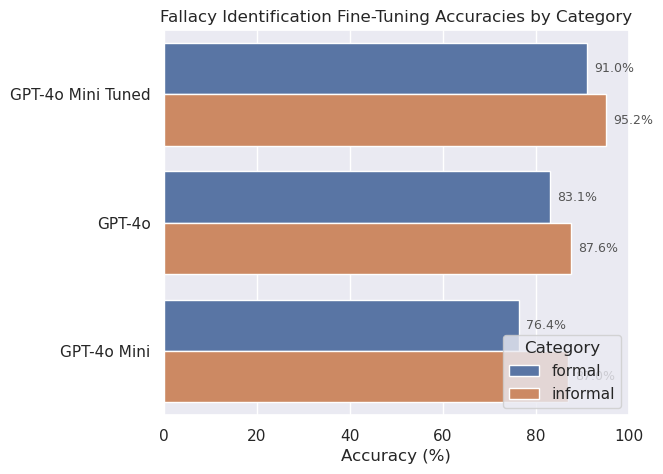

In [78]:
df_category_accuracies_long_e14 = pd.melt(df_category_accuracies_e14, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e14),
    figsize=(6, 5),
    title='Fallacy Identification Fine-Tuning Accuracies by Category',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_IDENTIFICATION, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

### Fallacy Confusion Metrics

In [79]:
df_llm_confusion_metrics_e14 = get_identification_confusion_metrics(df_confusion_matrices_e14, 'llm')
df_llm_confusion_metrics_e14.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
gpt_4o_mini_identification,1095,1116,44,65,0.953,0.961,0.944,0.953,0.055


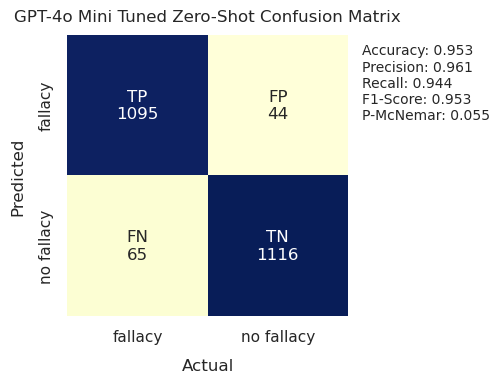

In [80]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e14.loc[LLM.GPT_4O_MINI_IDENTIFICATION.key],
    title=f'{LLM.GPT_4O_MINI_IDENTIFICATION.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

## Experiment 1.5: Fallacy Identification with rephrased zero-shot Prompt

A slight variation of the zero-shot identification prompt (experiment 1.1), to see whether false positives can be reduced by wording.

In [81]:
filename_e15 = 'data/fallacies_e15.csv'
df_fallacies_e15 = get_fallacy_df(filename_e15)

[2024-11-17 12:31:20] Loaded existing fallacy dataframe from data/fallacies_e15.csv.


### Scoring and Sanity Check

In [82]:
df_fallacies_e15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   step                        4640 non-null   object  
 1   entity                      4640 non-null   object  
 2   fallacy                     4640 non-null   category
 3   label                       4640 non-null   category
 4   category                    4640 non-null   category
 5   subcategory                 4640 non-null   category
 6   claude_3_5_sonnet_response  4640 non-null   object  
 7   gpt_4o_response             4640 non-null   object  
 8   gemini_1_5_flash_response   4640 non-null   object  
 9   claude_3_5_sonnet_pred      4640 non-null   int64   
 10  claude_3_5_sonnet_score     4640 non-null   int64   
 11  gpt_4o_pred                 4640 non-null   int64   
 12  gpt_4o_score                4640 non-null   int64   
 13  gemini_1_5_flash_p

In [83]:
# Since the prompt asks if there's a fallacy, and not if the reasoning is correct, the predictions are flipped
add_identification_scores(df_fallacies_e15, flip=True)

save_fallacy_df(df_fallacies_e15, filename_e15)

In [84]:
get_sanity_check(df_fallacies_e15)

,response_length_mean,missing_responses,invalid_predictions
claude_3_5_sonnet,2.5,0,0
gpt_4o,3.2,0,0
gemini_1_5_flash,2.8,0,0


### Overall Accuracies

In [85]:
_, df_subcategory_accuracies_e15, df_category_accuracies_e15, df_overall_accuracies_e15 = get_macro_accuracies(df_fallacies_e15)

In [86]:
df_overall_accuracies_e15 = df_overall_accuracies_e15.sort_values('accuracy', ascending=False)
df_overall_accuracies_e15

,accuracy
gpt_4o,85.979931
claude_3_5_sonnet,85.096873
gemini_1_5_flash,66.545903


- While GPT-4o and Claude 3.5 Sonnet perform similarly for the rephrased zero-shot prompt, Gemini 1.5 Flash accuracy dropped from 82.2% to 66.6%, which is unexpected.

### Overall Confusion Metrics



In [87]:
df_confusion_matrices_e15 = get_confusion_matrices(df_fallacies_e15, 'label')

In [88]:
df_overall_confusion_matrix_e15 = df_confusion_matrices_e15.groupby(['label'], observed=True).sum()
df_overall_confusion_matrix_e15

actual,1,0
label,,
1,6557,2020
0,403,4940


In [89]:
# We only care about the metrics for label 1 (fallacy)
df_overall_confusion_metrics_e15 = get_confusion_metrics(df_overall_confusion_matrix_e15)
df_overall_confusion_metrics_e15

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
1,6557,4940,2020,403,0.825934,0.764486,0.942098,0.844050,7.588338e-258
0,4940,6557,403,2020,0.825934,0.924574,0.709770,0.803056,7.588338e-258


### LLM Confusion Metrics

In [90]:
df_llm_confusion_metrics_e15 = get_identification_confusion_metrics(df_confusion_matrices_e15, 'llm')
df_llm_confusion_metrics_e15.round(3)

,tp,tn,fp,fn,accuracy,precision,recall,f1,p_mcnemar
claude_3_5_sonnet,2146,2019,301,174,0.898,0.877,0.925,0.900,0.000
gemini_1_5_flash,2278,857,1463,42,0.676,0.609,0.982,0.752,0.000
gpt_4o,2133,2064,256,187,0.905,0.893,0.919,0.906,0.001


- For Claude 3.5 Sonnet, the false positives dropped from 648 to 301, but for Gemini 1.5 Flash, they increased from 618 to 1463.
- The rephrased prompt did not have the desired effect of reducing false positives, at least not for all tested LLMs.

### Claude Sonnet Confusion Metrics

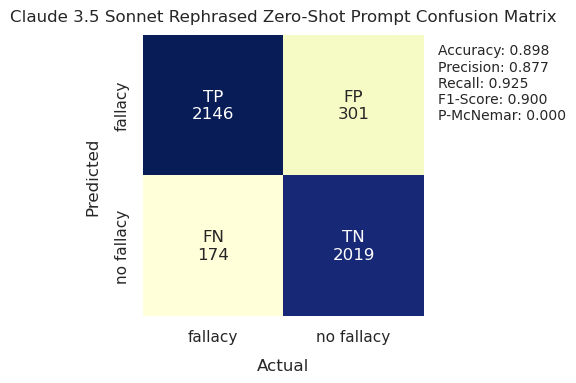

In [91]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e15.loc[LLM.CLAUDE_3_5_SONNET.key],
    title=f'{LLM.CLAUDE_3_5_SONNET.label} Rephrased Zero-Shot Prompt Confusion Matrix',
    figsize=(5, 4),
)

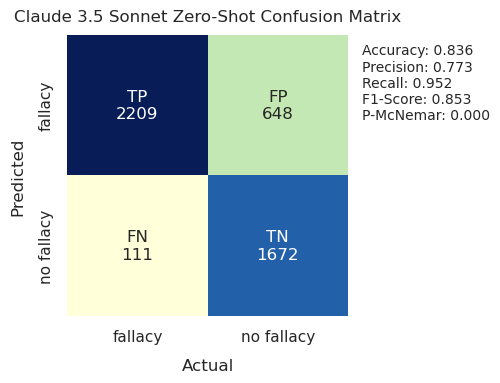

In [92]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e11.loc[LLM.CLAUDE_3_5_SONNET.key],
    title=f'{LLM.CLAUDE_3_5_SONNET.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

## Experiment 1.6: Fallacy Identification with zero-shot Prompt (Replication)

Are the results from the previous experiment replicable? Since temperature is set to 0, the models should produce the same output for the same input.

In [93]:
filename_e16 = 'data/fallacies_e16.csv'
df_fallacies_e16 = get_fallacy_df(filename_e16)

[2024-11-17 12:31:24] Loaded existing fallacy dataframe from data/fallacies_e16.csv.


### Scoring and Sanity Check

In [94]:
df_fallacies_e16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   step                       4640 non-null   object  
 1   entity                     4640 non-null   object  
 2   fallacy                    4640 non-null   category
 3   label                      4640 non-null   category
 4   category                   4640 non-null   category
 5   subcategory                4640 non-null   category
 6   gpt_4o_mini_response       4640 non-null   object  
 7   claude_3_haiku_response    4640 non-null   object  
 8   gemini_1_5_flash_response  4640 non-null   object  
 9   gpt_4o_mini_pred           4640 non-null   int64   
 10  gpt_4o_mini_score          4640 non-null   int64   
 11  claude_3_haiku_pred        4640 non-null   int64   
 12  claude_3_haiku_score       4640 non-null   int64   
 13  gemini_1_5_flash_pred      4640 n

In [95]:
add_identification_scores(df_fallacies_e16)

save_fallacy_df(df_fallacies_e16, filename_e16)

In [96]:
# Check completeness of responses, predictions and scores
df_fallacies_e16.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   step                       4640 non-null   object  
 1   entity                     4640 non-null   object  
 2   fallacy                    4640 non-null   category
 3   label                      4640 non-null   category
 4   category                   4640 non-null   category
 5   subcategory                4640 non-null   category
 6   gpt_4o_mini_response       4640 non-null   object  
 7   claude_3_haiku_response    4640 non-null   object  
 8   gemini_1_5_flash_response  4640 non-null   object  
 9   gpt_4o_mini_pred           4640 non-null   category
 10  gpt_4o_mini_score          4640 non-null   UInt8   
 11  claude_3_haiku_pred        4640 non-null   category
 12  claude_3_haiku_score       4640 non-null   UInt8   
 13  gemini_1_5_flash_pred      4640 n

In [97]:
get_sanity_check(df_fallacies_e16)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o_mini,3.4,0,0
claude_3_haiku,3.3,0,0
gemini_1_5_flash,2.4,0,0


### Overall Accuracies

In [98]:
_, df_subcategory_accuracies_e16, df_category_accuracies_e16, df_overall_accuracies_e16 = get_macro_accuracies(df_fallacies_e16)

In [99]:
df_overall_accuracies_e16 = df_overall_accuracies_e16.sort_values('accuracy', ascending=False)
df_overall_accuracies_e16

,accuracy
gpt_4o_mini,83.131385
gemini_1_5_flash,81.572429
claude_3_haiku,78.942127


### Differences between Experiments 1.1 and 1.6

In [100]:
for pred_col in [col for col in df_fallacies_e16.columns if col.endswith('_pred')]:
    llm_key = pred_col.replace('_pred', '')
    n_mismatches = (df_fallacies_e11[pred_col] != df_fallacies_e16[pred_col]).sum()
    print(f'Prediction mismatches for {llm_key}: {n_mismatches} ({n_mismatches / len(df_fallacies_e16):.1%})')

Prediction mismatches for gpt_4o_mini: 58 (1.2%)
Prediction mismatches for claude_3_haiku: 0 (0.0%)
Prediction mismatches for gemini_1_5_flash: 86 (1.9%)


- The predictions are not 100% identical, but the differences are small. Even though temperature is set to 0, not all models are deterministic.
- The accuracies are very similar, since some predictions flip from correct to incorrect and vice versa.